## Groundwater Whirls

This is a 10 layer steady-state problem involving anisotropic groundwater
flow.  The XT3D formulation is used to represent variable hydraulic
conductivitity ellipsoid orientations.  The resulting flow pattern consists
of groundwater whirls, as described in the XT3D documentation report.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-whirl"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 10  # Number of layers
nrow = 10  # Number of rows
ncol = 51  # Number of columns
delr = 100.0  # Spacing along rows ($m$)
delc = 100.0  # Spacing along columns ($m$)
top = 0.0  # Top of the model ($m$)
botm_str = "-100, -200, -300, -400, -500, -600, -700, -800, -900, -1000"  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type
k11 = 1.0  # Hydraulic conductivity in the 11 direction ($m/d$)
k22 = 0.1  # Hydraulic conductivity in the 22 direction ($m/d$)
k33 = 1.0  # Hydraulic conductivity in the 33 direction ($m/d$)
angle1_str = "45, 45, 45, 45, 45, -45, -45, -45, -45, -45"  # Rotation of the hydraulic conductivity ellipsoid in the x-y plane
inflow_rate = 0.01  # Inflow rate ($m^3/d$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
perlen = [1.0]
nstp = [1]
tsmult = [1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# Parse strings into lists
botm = [float(value) for value in botm_str.split(",")]
angle1 = [float(value) for value in angle1_str.split(",")]

# Solver settings
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        k22=k22,
        k33=k33,
        angle1=angle1,
        save_specific_discharge=True,
        xt3doptions=True,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    rate = np.zeros((nlay, nrow, ncol), dtype=float)
    rate[:, :, 0] = inflow_rate
    rate[:, :, -1] = -inflow_rate
    wellay, welrow, welcol = np.where(rate != 0.0)
    wel_spd = [((k, i, j), rate[k, i, j]) for k, i, j in zip(wellay, welrow, welcol)]
    wel_spd = {0: wel_spd}
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        pname="WEL",
    )
    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (3.5, 3.5)


def plot_spdis(sim):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        # create MODFLOW 6 cell-by-cell budget object
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            gwf.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0], gwf
        )

        ax = fig.add_subplot(1, 1, 1)
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"column": 0})
        pxs.plot_grid(linewidth=0.5)
        pxs.plot_vector(qx, qy, qz, normalize=True)
        ax.set_xlabel("y position (m)")
        ax.set_ylabel("z position (m)")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-spdis.png"
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    plot_spdis(sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 171.64 ms


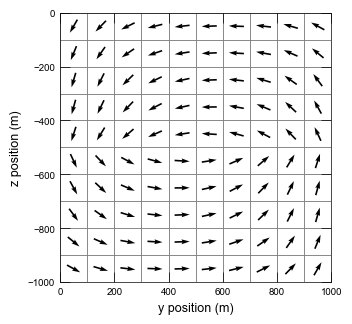

In [5]:
def scenario(idx, silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


# Simulated heads in the Whirl model with anisotropy in x direction.
scenario(0)